<a href="https://colab.research.google.com/github/nortonvanz/ML_Pocket_Reference/blob/main/notebooks/Titanic_Projeto_Base_Livro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Resolução do Titanic utilizando CRISP-DM, seguindo o livro Machine Learning: Guia de Referência Rápica.

# Faça uma pergunta

Crie um modelo preditivo, que classifique se um indivíduo sobreviveu à catástrofe do Titanic (sim / não).

In [ ]:
#Dataset e problema original no Kaggle: https://www.kaggle.com/competitions/titanic/data?select=train.csv

# Colete os Dados

## Imports

In [ ]:
#Pandas Profling: (pesado, apenas se necessário)
#!pip install ydata-profiling==4.1.2 #usar esta versão para o ydata-profiling funcionar no Colab

In [ ]:
#Análise de Colunas Colineares
!pip install rfpimp

#Análise de contribuições de features
!pip install shap

  Preparing metadata (setup.py) ... done
  Created wheel for rfpimp: filename=rfpimp-1.3.7-py3-none-any.whl size=10649 sha256=5f5d9b6953b6f4720118be0ea429ef3bfe05152a27c3d0578b437d60b1fe1a3e
  Stored in directory: /root/.cache/pip/wheels/6a/12/08/d5bc35127c8d69d39c1f3736a95419ab4763cc0c80ed65bf41
Successfully built rfpimp
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 9.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
#from ydata_profiling import ProfileReport #é o antigo pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import missingno
#import rfpimp
#import shap

#sklearn aux
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn import preprocessing as pp
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.impute import SimpleImputer



#models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost

from yellowbrick.classifier import ConfusionMatrix, ROCAUC
from yellowbrick.model_selection import LearningCurve
from yellowbrick.features import RFECV
from yellowbrick.classifier import ClassPredictionError, DiscriminationThreshold

## Carregar Dados

In [ ]:
#Carrega datasets do github:
!wget --quiet --show-progress https://raw.githubusercontent.com/nortonvanz/ML_Pocket_Reference/main/datasets/gender_submission.csv
!wget --quiet --show-progress https://hbiostat.org/data/repo/titanic3.xls -> mesma estrutura do livro

gender_submission.c 100%[===================>]   3.18K  --.-KB/s    in 0s      
titanic3.xls        100%[===================>] 277.50K  --.-KB/s    in 0.02s   


In [ ]:
df_raw = pd.read_excel('titanic3.xls')
df_sub = pd.read_csv('gender_submission.csv')

In [ ]:
df_raw.head(5)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [ ]:
df_sub.head(2)

,PassengerId,Survived
0,892,0
1,893,1


In [ ]:
df = df_raw.copy()

## Renomear Colunas

In [ ]:
df.columns

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')

In [ ]:
#converter tudo para minúsculo e com underline no lugar de espaços e pontos
df.columns = df.columns.str.replace(' ','_').str.replace('.','_').str.lower()
df.columns

<ipython-input-11-92dceb22e649>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.replace(' ','_').str.replace('.','_').str.lower()


Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home_dest'],
      dtype='object')

In [ ]:
df.head(3)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home_dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


# Análise Preliminar

In [ ]:
#descrição geral:
df.describe()
#count -> desconsidera NaN

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


In [ ]:
#Usar o Pandas Profiling para uma inspeção preliminar
#ProfileReport(df)

# Limpe os Dados

Objetivo é poder usar dados em um modelo. Para isto, será necessário avaliar:
- formato numérico (int ou float)
- valores ausentes (NaN no pandas)
- padronização (média 0 e std 1). Isto porque alguns modelos terão melhor desempenho.
- leaky features (vazam resposta no treino)

Colunas com pouca variação (não informativas) também são limpadas, dado que não serão úteis ao modelo. Não é o caso neste dataset.

In [ ]:
df.shape

(1309, 14)

In [ ]:
df.head(3)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home_dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


## Dados Faltantes

In [ ]:
#conferir nulos:
df.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home_dest     564
dtype: int64

In [ ]:
# % de nulos
np.round(df.isnull().mean() *100)

pclass        0.0
survived      0.0
name          0.0
sex           0.0
age          20.0
sibsp         0.0
parch         0.0
ticket        0.0
fare          0.0
cabin        77.0
embarked      0.0
boat         63.0
body         91.0
home_dest    43.0
dtype: float64

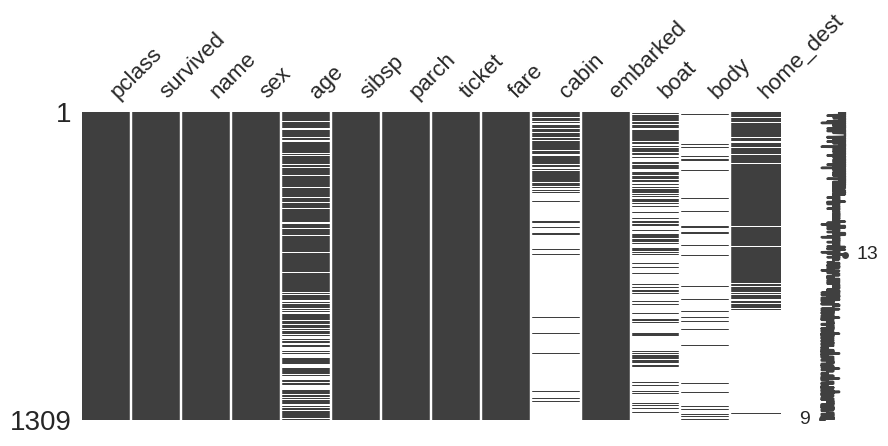

In [ ]:
#avaliar se há algum padrão nos nulos com lib missingno
missingno.matrix(df, figsize=(10, 4));

In [ ]:
#home.dest tem poucos missing para aprox. os primeiros 800 registros, depois praticamente todos são nulos.

In [ ]:
#ações a respeito dos nulos:

# cabin, boat e body tem mais da metade de dados nulos, logo tendem a não ser relevantes e serão descartadas
# body tem alta correlação com survived (target), logo causa vazamento de dados e será descartada
# boat também causa vazamento, informando que o passageiro sobreviveu, logo também será discartada
# home.dest também tem mais de 40% de nulos, e será descartada

In [ ]:
#analisar colunas object que tendem a ser categóticas, com value_counts()
df.sex.value_counts()

male      843
female    466
Name: sex, dtype: int64

In [ ]:
#o pandas ignora NAN por padrão, para exibir:
df.embarked.value_counts(dropna=False)

S      914
C      270
Q      123
NaN      2
Name: embarked, dtype: int64

Algumas possibilidades para tratamento de NANs (dados ausentes):
- imputar valor mais comum -> sklearn SimpleImputer
- one hot encoding, onde será 0 em todas colunas
- explorar dados e imputar com alguma outra lógica

Em último caso:
- descartar linhas -> df.dropna()
- descartar colunas -> df.drop(columns="col_name")

In [ ]:
#imputar dados na coluna boat, apenas como exemplo:
df.boat.value_counts(dropna=False)[:8]

NaN    823
13      39
C       38
15      37
14      33
4       31
10      29
5       27
Name: boat, dtype: int64

In [ ]:
#5 primeiras linhas
df.boat[:5]

0      2
1     11
2    NaN
3    NaN
4    NaN
Name: boat, dtype: object

In [ ]:
#imputar o valor mais frequente
imputer = SimpleImputer(missing_values = np.nan, strategy ='most_frequent') # média   #strategy='median' ou 'most_frequent'
df.boat = imputer.fit_transform(df["boat"].values.reshape(-1, 1))

In [ ]:
#após dados imputados
df.boat[:5]

0     2
1    11
2    13
3    13
4    13
Name: boat, dtype: object

In [ ]:
#dropar colunas, conforme planejado
df = df.drop( columns = ["name","ticket","home_dest","boat","body","cabin"] )

In [ ]:
df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1,1,female,29.0000,0,0,211.3375,S
1,1,1,male,0.9167,1,2,151.5500,S
2,1,0,female,2.0000,1,2,151.5500,S
3,1,0,male,30.0000,1,2,151.5500,S
4,1,0,female,25.0000,1,2,151.5500,S


In [ ]:
#temos colunas com NAN que permaneceram no dataset, e vamos tratar
df.isnull().sum()

pclass        0
survived      0
sex           0
age         263
sibsp         0
parch         0
fare          1
embarked      2
dtype: int64

In [ ]:
#age e median: para estas colunas que tem NULLs e são float, vamos imputar a mediana da coluna
#poderia usar o mesmo método acima, com a estratégia = median

# medianas
meds = df[["age","fare"]].median()
meds

age     28.0000
fare    14.4542
dtype: float64

In [ ]:
df[["age","fare"]] = df[["age","fare"]].fillna(meds)
df.isnull().sum()

pclass      0
survived    0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    2
dtype: int64

In [ ]:
#para resolver os 2 missings de embarked (object), usar a abordagem mais frequente, já utilizada antes:

imputer2 = SimpleImputer(missing_values = np.nan, strategy ='most_frequent') # média   #strategy='median' ou 'most_frequent'
df.embarked = imputer2.fit_transform(df["embarked"].values.reshape(-1, 1))

In [ ]:
#resolvido
df.isnull().sum()

pclass      0
survived    0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
dtype: int64

## Tipos de dados

In [ ]:
df.dtypes
# vemos normalmente int, float, datetime e object(string)
# o pandas tenta inferir, e seta object quando não conseguir identificar

pclass        int64
survived      int64
sex          object
age         float64
sibsp         int64
parch         int64
fare        float64
embarked     object
dtype: object

In [ ]:
#age possui valores float, o que é curioso
#poderia arredondar para int, mas como vamos normalizar os dados, será mantido assim mesmo
df.age[:5]

0    29.0000
1     0.9167
2     2.0000
3    30.0000
4    25.0000
Name: age, dtype: float64

# Crie as Features

In [ ]:
df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1,1,female,29.0000,0,0,211.3375,S
1,1,1,male,0.9167,1,2,151.5500,S
2,1,0,female,2.0000,1,2,151.5500,S
3,1,0,male,30.0000,1,2,151.5500,S
4,1,0,female,25.0000,1,2,151.5500,S


In [ ]:
#criar dummies a partir das 2 colunas categóricas, para ter cada categoria em uma coluna
df = pd.get_dummies(df)

In [ ]:
df.head()

,pclass,survived,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,1,1,29.0000,0,0,211.3375,1,0,0,0,1
1,1,1,0.9167,1,2,151.5500,0,1,0,0,1
2,1,0,2.0000,1,2,151.5500,1,0,0,0,1
3,1,0,30.0000,1,2,151.5500,0,1,0,0,1
4,1,0,25.0000,1,2,151.5500,1,0,0,0,1


In [ ]:
# Temos agora colunas com correlação perfeita (sex_female vs sex_male), logo removeremos uma delas.
# Removemos também colunas com alta correlação positiva ou negativa, pois explicam a mesma parte do fenômeno.
# Além disso, a multicolinearidade pode causar impactos na interpretação das feature importances e dos coeficientes de alguns modelos.

In [ ]:
df = df.drop(columns="sex_male")

In [ ]:
df.head()

,pclass,survived,age,sibsp,parch,fare,sex_female,embarked_C,embarked_Q,embarked_S
0,1,1,29.0000,0,0,211.3375,1,0,0,1
1,1,1,0.9167,1,2,151.5500,0,0,0,1
2,1,0,2.0000,1,2,151.5500,1,0,0,1
3,1,0,30.0000,1,2,151.5500,0,0,0,1
4,1,0,25.0000,1,2,151.5500,1,0,0,1


In [ ]:
#exportar local:
df.to_csv('df_titanic_pos_criar_features.csv') #will export index, keep it!

In [ ]:
#carregar local:
df = pd.read_csv('df_titanic_pos_criar_features.csv', index_col=0)
df

,pclass,survived,age,sibsp,parch,fare,sex_female,embarked_C,embarked_Q,embarked_S
0,1,1,29.0000,0,0,211.3375,1,0,0,1
1,1,1,0.9167,1,2,151.5500,0,0,0,1
2,1,0,2.0000,1,2,151.5500,1,0,0,1
3,1,0,30.0000,1,2,151.5500,0,0,0,1
4,1,0,25.0000,1,2,151.5500,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
1304,3,0,14.5000,1,0,14.4542,1,1,0,0
1305,3,0,28.0000,1,0,14.4542,1,1,0,0
1306,3,0,26.5000,0,0,7.2250,0,1,0,0
1307,3,0,27.0000,0,0,7.2250,0,1,0,0


# Separe as Amostras

Separação entre features e var alvo:

Termos para os dados:

X -> features

y -> Target

In [ ]:
y = df.survived #criar uma Series
X = df.drop(columns="survived") #criar novo DataFrame

In [ ]:
y.head(3)

0    1
1    1
2    0
Name: survived, dtype: int64

In [ ]:
X.head(3)

,pclass,age,sibsp,parch,fare,sex_female,embarked_C,embarked_Q,embarked_S
0,1,29.0000,0,0,211.3375,1,0,0,1
1,1,0.9167,1,2,151.5500,0,0,0,1
2,1,2.0000,1,2,151.5500,1,0,0,1


Separação entre treino e teste

In [ ]:
#estratifica pela y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43, stratify=y)

# EDA

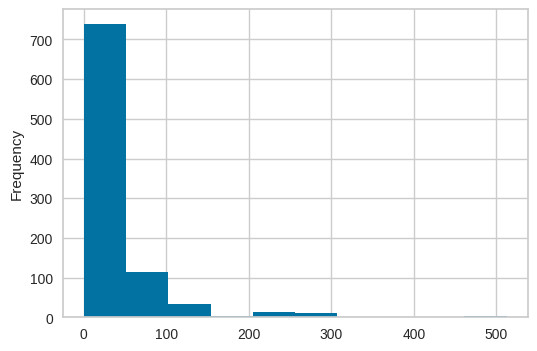

In [ ]:
#histograma: mostra a distribuição dos dados

#fare
fig, ax = plt.subplots(figsize=(6, 4));
X_train.fare.plot(kind="hist", ax=ax);

In [ ]:
#a grande maioria dos passageiros tinha uma fare baixa

In [ ]:
#Juntando X_train com y_train, para aprofundar as análises:
df_train = pd.concat([X_train, y_train], axis=1)
df_train.head()

,pclass,age,sibsp,parch,fare,sex_female,embarked_C,embarked_Q,embarked_S,survived
239,1,31.0,0,0,50.4958,0,0,0,1,0
934,3,4.0,0,2,22.0250,1,0,0,1,1
290,1,52.0,1,1,79.6500,0,0,0,1,0
1089,3,20.0,0,0,9.2250,0,0,0,1,0
1161,3,16.0,0,0,8.0500,0,0,0,1,0


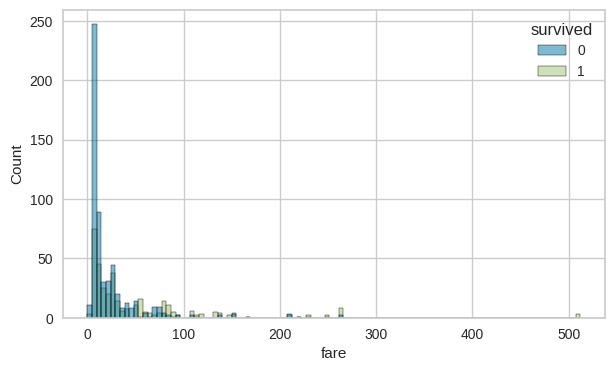

In [ ]:
# #usando seaborn
fig, ax = plt.subplots(figsize=(7, 4))
sns.histplot(data=df_train, x="fare", hue="survived");

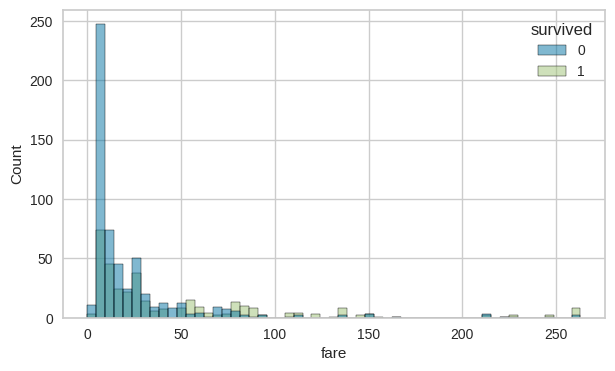

In [ ]:
#remover fare > 300, para melhor visualizar
df_train_fare300 = df_train.loc[df_train.fare < 300]

fig, ax = plt.subplots(figsize=(7, 4))
sns.histplot(data=df_train_fare300, x="fare", hue="survived");

In [ ]:
#percebe-se que há mais sobreviventes entre os passageiros com fare maior

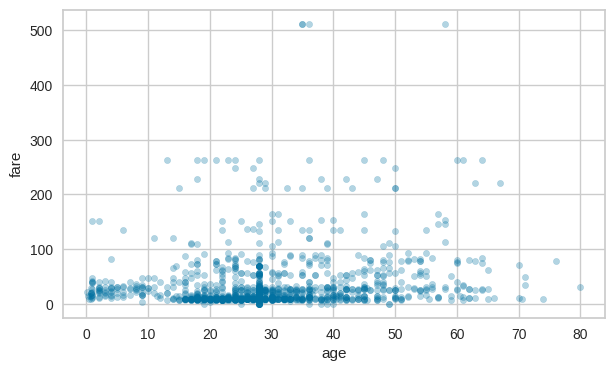

In [ ]:
#gráfico de dispersão: mostra o relacionamento entre duas colunas numéricas
#cruzando fare com age
fig, ax = plt.subplots(figsize=(7, 4));
X.plot.scatter(x="age", y="fare", ax=ax, alpha=0.3);

In [ ]:
#Não parece haver muita correlação entre esses dois atributos.

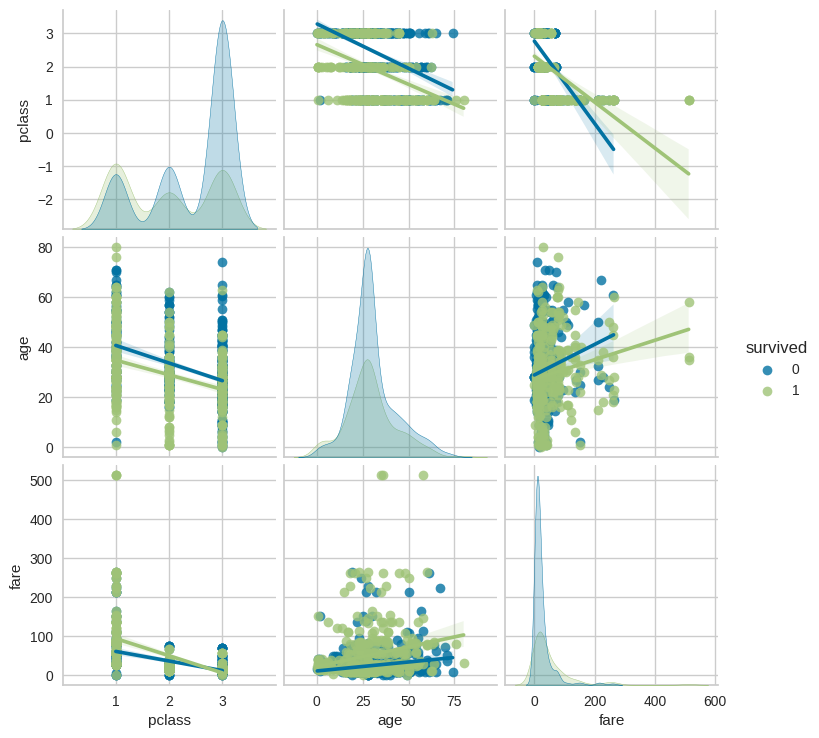

In [ ]:
#matriz de pares
#fig, ax = plt.subplots(figsize=(6, 6))

vars = ["pclass", "age", "fare"]
sns.pairplot(df_train, vars=vars, hue="survived", kind="reg");

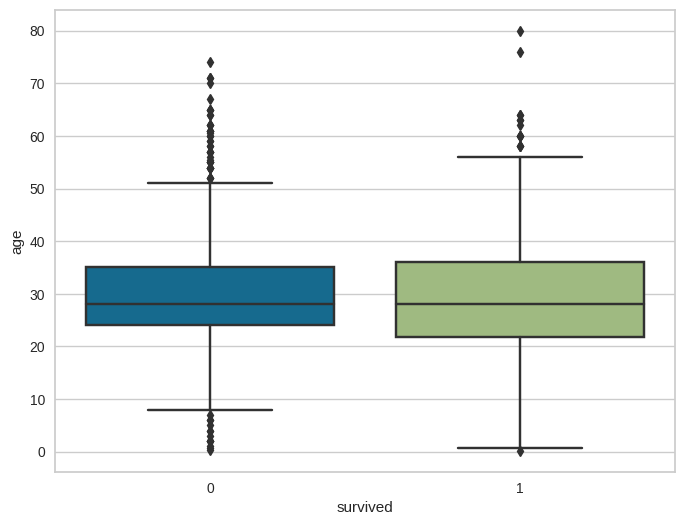

In [ ]:
#Boxplot: mostra a distribuição dos dados
#age
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x="survived", y="age", data=df_train);

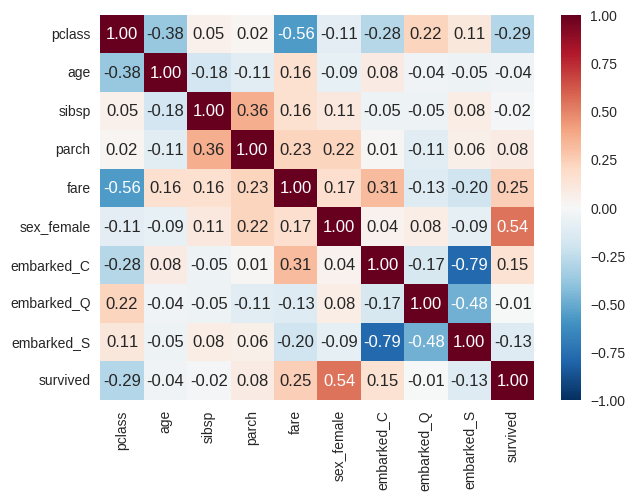

In [ ]:
#Correlação

fig, ax = plt.subplots(figsize=(7, 5))
ax = sns.heatmap(df_train.corr(),fmt=".2f",annot=True,ax=ax,cmap="RdBu_r",vmin=-1,vmax=1);

In [ ]:
#há uma correlação média negativa entre cada um dos 3 locais de embarque
#fare possui correlação média com pclass

<ipython-input-101-3c5e396cf015>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(


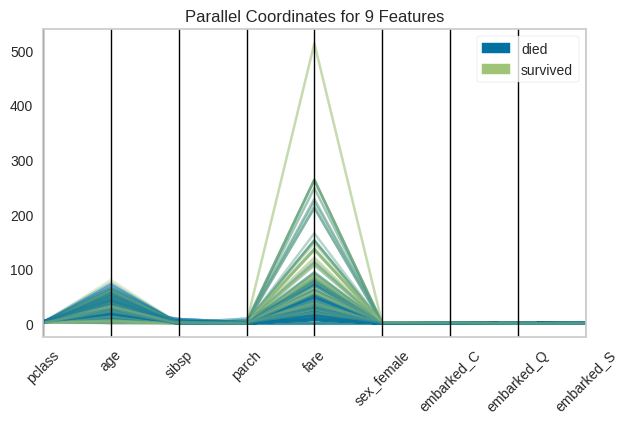

In [ ]:
#Gráfico de coordenadas paralelas, para visualizar os agrupamentos
from yellowbrick.features import ParallelCoordinates

fig, ax = plt.subplots(figsize=(7, 4))
pc = ParallelCoordinates(
classes=["died", "survived"],
features=X.columns,
)
pc.fit(X_train, y_train)
pc.transform(X_train)
ax.set_xticklabels(
ax.get_xticklabels(), rotation=45
)
pc.poof();

In [ ]:
#há um maior número de sobreviventes nas faixas de fare mais elevadas

# Normalize os dados

In [ ]:
#Normalizar os dados ajudará os modelos que dependem de métrica de distâncias a terem um melhor desempenho.
#Assim, os modelos não tratarão as variáveis com escalas maiores, como mais importantes que as que tem escalas menores.
#Árvores não tem este requisito.

#Standardizarion: É Redimensionar os dados para ter uma média de 0 e um desvio padrão de 1 (unidade de variância).
  #Sklean: "standardize features by removing the mean and scaling to unit variance."

In [ ]:
#as variáveis dummy podem ser ignoradas, sendo binárias.

In [ ]:
X_train.parch.value_counts()

-0.479338    687
 0.717048    131
 1.913435     79
 3.109821      7
 4.306207      5
 5.502594      5
 6.698980      2
Name: parch, dtype: int64

In [ ]:
#X_train2 =X_train.copy()
#X_train = X_train2.copy()

In [ ]:
X_train.columns #9 cols

Index(['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_female', 'embarked_C',
       'embarked_Q', 'embarked_S'],
      dtype='object')

In [ ]:
#usando standard scaler: (premissa: dados tem distribuição normal)

#instancia
sca = pp.StandardScaler()

In [ ]:
X_train.head(1)

,pclass,age,sibsp,parch,fare,sex_female,embarked_C,embarked_Q,embarked_S
92,1,17.0,1,0,57.0,1,0,0,1


In [ ]:
#Standardizarion em X_train (transforma em array numpy)
X_train_aux = sca.fit_transform(X_train)
X_train_aux[:1]

array([[-1.62178658, -0.93395373,  0.45782052, -0.47933821,  0.53376757,
         1.32004355, -0.49111344, -0.33615653,  0.64819367]])

In [ ]:
#nomes das colunas
cols = ['pclass', 'age', 'sibsp', 'parch', 'fare', 'sex_female', 'embarked_C',
       'embarked_Q', 'embarked_S']

In [ ]:
#retorna ao formato df
X_train = pd.DataFrame(X_train_aux, columns=cols)
X_train[:1]

,pclass,age,sibsp,parch,fare,sex_female,embarked_C,embarked_Q,embarked_S
0,-1.621787,-0.933954,0.457821,-0.479338,0.533768,1.320044,-0.491113,-0.336157,0.648194


In [ ]:
#aplica as mesmas transformações para os dados de teste:
X_test_aux = sca.fit_transform(X_test)
X_test = pd.DataFrame(X_test_aux, columns=cols)
X_test[:1]

,pclass,age,sibsp,parch,fare,sex_female,embarked_C,embarked_Q,embarked_S
0,-1.392158,0.42387,-0.46136,-0.375206,7.969408,-0.711159,1.808795,-0.28748,-1.490406


# Selecione as Features

In [ ]:
#já foi feita uma seleção prévia de fatures na etapa de limpeza de dados

#O objetivo da features selection é selecionar as features úteis para o modelo.
#Maldição da dimensionalidade: problema causado pelo aumento exponencial do volume associado à adição de dimensões extras (features) ao espaço euclidiano

## Remover features colineares

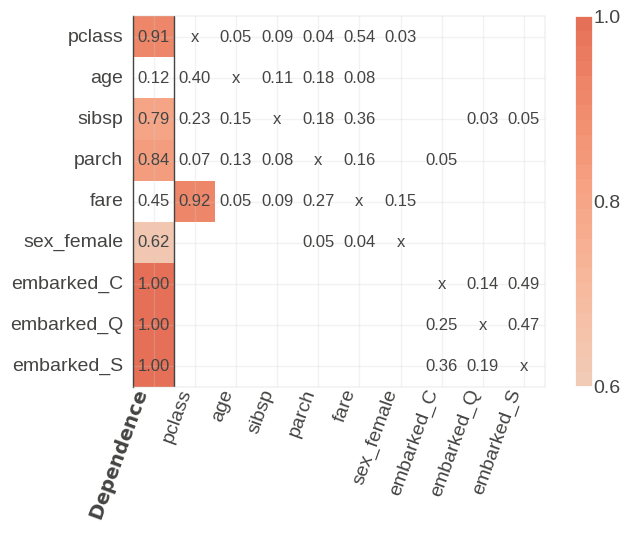

In [ ]:
#Uma estratégia para remover features desnecessárias é remover colunas colineares

#Podemos usar a função correlated_columns para encontrar colunas visualmente, colunas que tenham um coeficiente de correlação maior ou igual a 0,95:

#A função plot_dependence_heatmap faz o treinamento de uma floresta aleatória (random forest) para cada coluna numérica a partir das outras colunas em um conjunto de dados de treinamento.
#O valor da dependência é a pontuação R2 das estimativas OOB (Out-Of-Bag) para a predição dessa coluna

rfpimp.plot_dependence_heatmap(
rfpimp.feature_dependence_matrix(X_train),
value_fontsize=12,
label_fontsize=14)
fig = plt.gcf()

In [ ]:
#A forma sugerida de usar esse gráfico é encontrar valores próximos de 1 no eixo Y (fora coluna Dependente). O rótulo no eixo X é o atributo que faz a predição do rótulo do eixo Y.
#Se um atributo faz a predição de outro, podemos remover o atributo previsto (o atributo no eixo Y).
#Em nosso exemplo, fare pode ser previso através de pclass. Logo, será removido, por conter um conteúdo de informação muito parecido com pclass.

In [ ]:
X_train.head(3)

,pclass,age,sibsp,parch,fare,sex_female,embarked_C,embarked_Q,embarked_S
0,0,-0.933954,1,0,0.533768,1,0,0,1
1,2,-0.101932,0,0,-0.489379,0,0,0,1
2,2,-0.101932,6,2,0.796086,0,0,0,1


In [ ]:
#remover fare do treino e teste:
X_train = X_train.drop(['fare'], axis=1)
X_test = X_test.drop(['fare'], axis=1)

In [ ]:
X_train.head(3)

,pclass,age,sibsp,parch,sex_female,embarked_C,embarked_Q,embarked_S
0,0,-0.933954,1,0,1,0,0,1
1,2,-0.101932,0,0,0,0,0,1
2,2,-0.101932,6,2,0,0,0,1


## Eliminação recursiva de features

RFECV(ax=<Axes: >, cv=5,
      estimator=RandomForestClassifier(class_weight='balanced', max_depth=2,
                                       n_estimators=300, random_state=42))

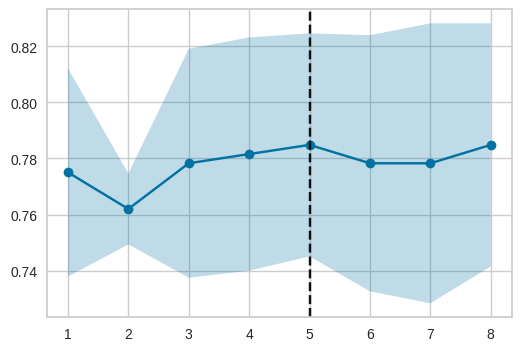

In [ ]:
#A eliminação recursiva de atributos removerá os atributos mais fracos, e então treinará um modelo
  #PS: considerar que os parâmetros do modelo impactam. Foi rodado novamente, após o fine tuning, com max_depth=2, reduzindo o verfiting.

fig, ax = plt.subplots(figsize=(6, 4))
rfe = RFECV(RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42, max_depth=2),cv=5)
rfe.fit(X_train, y_train)

In [ ]:
#manter as 9 features, pois o resultado ficou muito parecido com o utilizando 5

X_train.columns[rfe.support_]

Index(['pclass', 'age', 'parch', 'sex_female', 'embarked_C'], dtype='object')

In [ ]:
#X_train_antes_rem = X_train.copy()

In [ ]:
#aplicando em treino e teste (não foram removidas features, desnecessário)
#X_train = X_train[['pclass', 'age', 'fare', 'sex_female']]
#X_test = X_test[['pclass', 'age', 'fare', 'sex_female']]

In [ ]:
X_train.head()

,pclass,age,sibsp,parch,sex_female,embarked_C,embarked_Q,embarked_S
0,0,-0.933954,1,0,1,0,0,1
1,2,-0.101932,0,0,0,0,0,1
2,2,-0.101932,6,2,0,0,0,1
3,2,0.351899,1,1,0,0,0,1
4,2,-0.101932,0,0,0,0,0,1


# Modelo Base

In [ ]:
#o DummyClassifier serve como um modelo realmente simples, para dar uma ideia de como está nossos outros modelos:
  #por defaul, usa como stratrgy: “prior”: the predict method always returns the most frequent class label in the observed y argument passed to fit.

In [ ]:
y_train.value_counts()

0    564
1    352
Name: survived, dtype: int64

In [ ]:
#vai prever sempre 0 (survived = Não)

In [ ]:
#instanciar
bm = DummyClassifier()
#fitar com treino
bm.fit(X_train, y_train)

DummyClassifier()

In [ ]:
#o modelo Dummy que chuta sempre a classe majoritária.
#Considerar que precisão é uma métrica que se torna enganosa, com dados desbalanceados: se eu tiver 1 caso positivo de 10k negativos, prevendo tudo negativo, um modelo poderia ter 99% de precisão.

# Modelos Diversos

In [ ]:
#juntar treino num só dataframe
X = pd.concat([X_train, X_test])
#juntar teste num só dataframe
y = pd.concat([y_train, y_test])

In [ ]:
#PS: como não há nenhuma tunagem nos modelos, as árvores por exemplo tendem a overfitar.. é só para ter uma idea mesmo

for model in [
  DummyClassifier, #só vai dar resultados com AUC
  LogisticRegression,
  DecisionTreeClassifier,
  KNeighborsClassifier,
  GaussianNB,
  SVC,
  RandomForestClassifier,
  xgboost.XGBClassifier
]:

  cls = model()
  kfold = KFold(n_splits=10)

  #aplica cross validation, e avalia a performance com f1-Score:
  s = cross_val_score(cls, X, y, scoring="f1", cv=kfold)

  #resultados
  print(f"{model.__name__:22}   F1:{s.mean():.3f}     STD: {s.std():.2f}")

  #um algoritmo que tenha um F1 um pouco menor que outro, mas um desvio-padrão menor, pode ser uma melhor opção.

DummyClassifier          F1:0.000     STD: 0.00
LogisticRegression       F1:0.694     STD: 0.06
DecisionTreeClassifier   F1:0.654     STD: 0.07
KNeighborsClassifier     F1:0.663     STD: 0.08
GaussianNB               F1:0.692     STD: 0.07
SVC                      F1:0.728     STD: 0.07
RandomForestClassifier   F1:0.678     STD: 0.06
XGBClassifier            F1:0.697     STD: 0.06


In [ ]:
#O SVC foi o modelo que melhor performou. Considerar que não foi feita tunagem alguma de hiperparâmetros.

# Crie o modelo

In [ ]:
#Usaremos um RF, que tende a ter bons resultados sem maior tuning.

In [ ]:
#instanciar
rf = RandomForestClassifier(n_estimators=100, random_state=42)
#fitar
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Balanceando as classes

In [ ]:
# Se você estiver classificando dados e as classes não estiverem relativamente balanceadas quanto ao tamanho, a distorção em direção às classes mais populares poderão transparecer em seu modelo.
# Por exemplo, se você tiver 1 caso positivo e 99 casos negativos, poderá obter 99% de exatidão simplesmente classificando tudo como negativo.
# Há várias opções para lidar com classes desbalanceadas (imbalanced classes):
  # Muitos modelos de classificação do scikit-learn aceitam o parâmetro class_weight. Defini-lo com 'balanced' tentará regularizar as classes minoritárias e incentivará o modelo a classificá-las corretamente.
  # XGBoost, KNN e vários modelos tem outros atributos para lidar com balanceamento já implementados.
  # Upsampling da minoria dos dados
  # Downsampling da maioria dos dados

In [ ]:
rf_balanced = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, max_depth=3)
rf_balanced.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=3, random_state=42)

Visualizando a árvore

In [ ]:
#Visualizando a árvore de decisão com dtreeviz, sugerida no livro ML guia de ref. rápida:
  #Não funcionou, usar  do scikit-learn, que é easy e funciona liso.

# Avalie o modelo

Modelo sem balanceamento

In [ ]:
#Avaliar se o modelo consegue generalizar bem em dados de teste (nunca antes vistos)
#Vamos usar a métrica F1: Resume precision e recall, sendo a média harmônica entre ambos.
y_hat = rf.predict(X_test)
round(metrics.f1_score( y_test, y_hat ),3)

0.684

Após o balanceamento de classes

In [ ]:
#F1
y_hat = rf_balanced.predict(X_test)
round(metrics.f1_score( y_test, y_hat ),3)

0.738

In [ ]:
#A performance melhorou, após o balanceamento.

## Feature importances

In [ ]:
#Inspecionar Feature importances: informa quanto cada feature contribui para o modelo. Quanto maior o erro causado com a remoção da feature, maior é a sua importância.
importances = rf_balanced.feature_importances_

In [ ]:
print("Features mais importantes:")
for col, val in sorted(
    zip(
        X_train.columns,
        rf_balanced.feature_importances_,
    ),
    key=lambda x: x[1],
    reverse=True,
):
  print(f"{col:10}{val:10.3f}")

Features mais importantes:
sex_female     0.475
pclass         0.197
age            0.083
parch          0.083
embarked_C     0.066
sibsp          0.050
embarked_S     0.036
embarked_Q     0.010


## Otimize o Modelo

In [ ]:
#O autor exemplifica com o Grid Search CV. Ele funciona bem para datasets pequenos, como este.
rfh = RandomForestClassifier()
params = {
    "n_estimators": [150],
   # "min_samples_leaf": [2, 5],
    'max_leaf_nodes': [20, 40],
    'max_depth': [3], #já controla o crescimento da árvore
    "random_state": [42]
}

rfcv = GridSearchCV(rfh, params, n_jobs=-1).fit(X_train, y_train)
print(f"Os melhores parâmetros são: {rfcv.best_params_}")

Os melhores parâmetros são: {'max_depth': 3, 'max_leaf_nodes': 20, 'n_estimators': 150, 'random_state': 42}


In [ ]:
#usar este modelo com melhores params no nosso dataset:
rfcv.fit(X_train, y_train)
rff_yhat = rfcv.predict(X_test)

#F-1 score:
round(metrics.f1_score( y_test, rff_yhat ),3)

0.736

In [ ]:
#não houve aqui uma melhor performance após o fine tuning, mas mais combinações podem ser testadas para melhorar a performance.
#Vamos seguir com o modelo balanceado por hora

In [ ]:
#Importante lembrar: o fine tuning do GridSearchCV vai aumentar pouco a performance do modelo.
#Investir mais energia na feature engeneering e feature selection, vai gerar mais ganho de performance.

In [ ]:
#salvar com pickle no Colab
pickle_out = open("rf_balanced_pickle", 'wb')
pickle.dump = (rf_balanced, pickle_out)

In [ ]:
#carregar
pic = pickle.dumps(rf_balanced)  #/content/rf_balanced_pickle
rf_balanced_pickle = pickle.loads(pic)
rf_balanced_pickle

RandomForestClassifier(class_weight='balanced', max_depth=3, random_state=42)

## Matriz de Confusão

In [ ]:

y_pred = rf_balanced.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[203,  40],
       [ 39, 111]])

/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


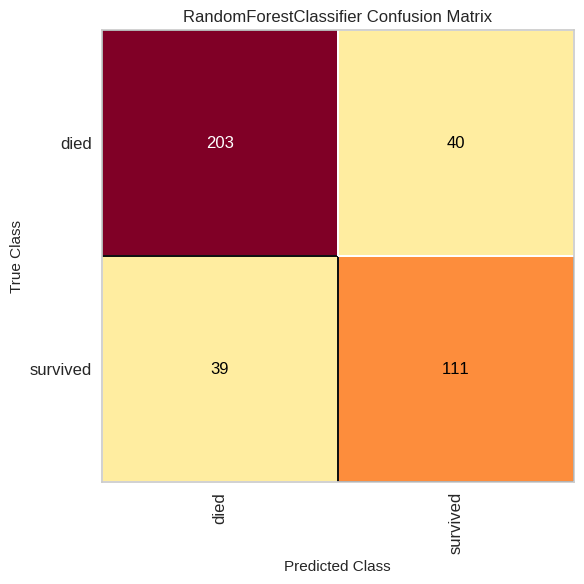

In [ ]:
mapping = {0: "died", 1: "survived"}
fig, ax = plt.subplots(figsize=(6, 6))

#yellowbricks
cm_viz = ConfusionMatrix(
  rf_balanced,
  classes=["died", "survived"],
  label_encoder=mapping,
)
cm_viz.score(X_test, y_test);
cm_viz.poof();

In [ ]:
#Um bom classificador teria todos os valores na diagonal principal, e zeros nas demais células.

## Erro de predição de classe

In [ ]:
#O gráfico de erro de predição de classe do Yellowbrick é um gráfico de barras que exibe uma matriz de confusão, mas de forma mais amigável

/usr/local/lib/python3.10/dist-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(


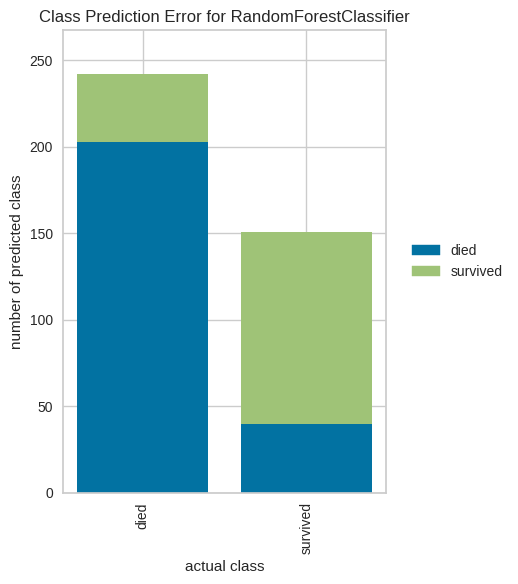

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

cpe_viz = ClassPredictionError(rf_balanced, classes=["died", "survived"]);
cpe_viz.score(X_test, y_test);
cpe_viz.poof();

In [ ]:
#Na parte superior da barra à esquerda, estão as pessoas que não sobreviveram, mas para as quais foi previsto que sobreviveram (falso-positivos).
#Na parte inferior da barra à direita, estão as pessoas que sobreviveram, mas para as quais o modelo fez a predição de que não sobreviveram (falso-negativos).
#Ambos são previsões incorretas do modelo.

## Curva de Aprendizado

In [ ]:
#É usada para nos dizer se temos dados de treinamento suficientes.
#Avaliando em cima dos dados de treino apenas

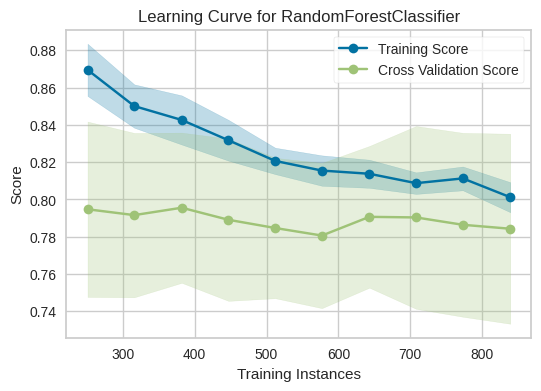

In [ ]:
#usando o modelo rf_balanced, balanceado e com max_depth
fig, ax = plt.subplots(figsize=(6, 4))

cv = StratifiedKFold(12)
sizes = np.linspace(0.3, 1.0, 10)
lc_viz = LearningCurve(rf_balanced, cv=cv, train_sizes=sizes, scoring="f1_weighted", n_jobs=-1, ax=ax)
lc_viz.fit(X_train, y_train)
lc_viz.poof();

In [ ]:
#Sobre o gráfico:

#O gráfico mostra os dados de treinamento e a pontuação para validação cruzada à medida que criamos modelos com mais amostras.
#Se a pontuação da validação cruzada continuar a subir, por exemplo, poderá ser um sinal de que mais dados ajudariam o modelo a ter um melhor desempenho.

#Se houver variabilidade (uma área sombreada grande) nos dados de treinamento, é sinal de que o modelo sofre de erros de bias, e é simples demais (há underfitting).
#Se houver variabilidade na pontuação para validação cruzada, é porque o modelo está sujeito a erros de variância, e é complicado demais (há overfitting).
#Outro sinal de que o modelo apresenta overfitting é o fato de que o desempenho para o conjunto de dados de validação é muito pior do que o desempenho para o conjunto de dados de treinamento.

In [ ]:
#Análise:

#É possível ver que o score em treino e validação são próximos, logo o modelo poderia ser refinado, mas sem grandes ganhos no fine tuning.
#Adicionar mais dados não indica melhorar o modelo, que segue estável com relaçao a performance, a medida que se adicionam mais dados, após aprox. 600 linhas.

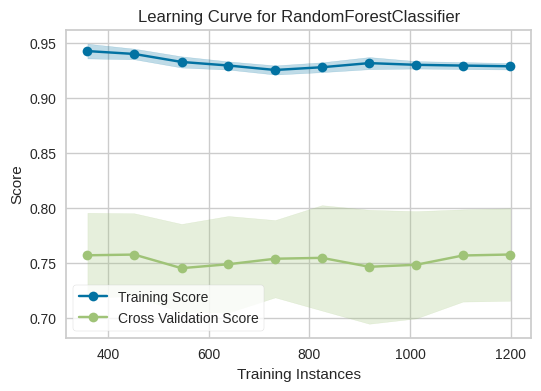

In [ ]:
#usando o modelo rf (não balanceado, e sem max_depth=3, overfitando bastante)
fig, ax = plt.subplots(figsize=(6, 4))

cv = StratifiedKFold(12)
sizes = np.linspace(0.3, 1.0, 10)
lc_viz = LearningCurve(rf, cv=cv, train_sizes=sizes, scoring="f1_weighted", n_jobs=-1, ax=ax)
lc_viz.fit(X, y)
lc_viz.poof();

In [ ]:
#A performance em validação diminuiu bastante, confirmando o overfitting já conhecido, devido a não poda do modelo de árvore.

In [ ]:
#usar agora o modelo rf_balanced

In [ ]:
#treinar um novo classifier balanceado, reduzindo ainda mais o overfitting: aumentar o número de árvores (estimators), e setar um max_depth menor ainda
rf_balanced2 = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42, max_depth=2)
rf_balanced2.fit(X_train, y_train)

#F1
y_hat = rf_balanced2.predict(X_test)
round(metrics.f1_score( y_test, y_hat ),3)

0.736

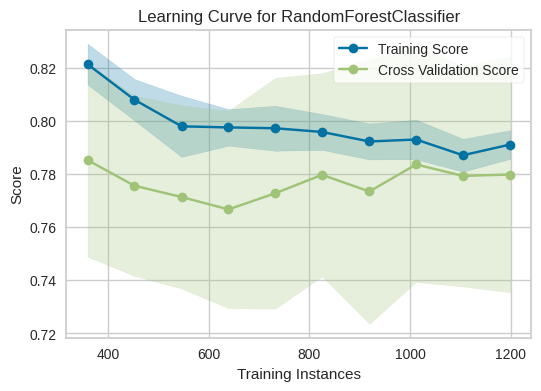

In [ ]:
#max_depth = 2
#plotar novamente o gráfico
fig, ax = plt.subplots(figsize=(6, 4))

cv = StratifiedKFold(12)
sizes = np.linspace(0.3, 1.0, 10)
lc_viz = LearningCurve(rf_balanced2, cv=cv, train_sizes=sizes, scoring="f1_weighted", n_jobs=-1, ax=ax)
lc_viz.fit(X, y)
lc_viz.poof();

In [ ]:
#a situação não melhorou, ficando praticamente na mesma. Seguir com o modelo usado até então: df_balanced

## Limiar de discriminação

In [ ]:
#discrimination threshold

#A maioria dos classificadores binários que fazem a predição de probabilidades tem um limiar de discriminação (discrimination threshold) de 50%.
#Se a probabilidade prevista estiver acima de 50%, o classificador atribuirá um rótulo positivo.
#O plot abaixo varia esse valor de limiar entre 0 e 100 e mostra o impacto na precisão, no recall (revocação), em f1 e na taxa de fila (queue rate).
#A taxa de fila (queue rate) é a porcentagem de previsões acima do limiar. Podemos considerá-la como a porcentagem de casos a serem analisados se você estivesse lidando com fraudes.
#Se você tiver o custo para cálculos positivos, negativos e errôneos, é possível determinar o limiar com o qual você se sentiria confortável.
#O gráfico a seguir é conveniente para verificar qual é o limiar de discriminação que maximizará a f1, ou para ajustar a precisão ou o recall com um número aceitável quando combinados com a taxa de fila.
#O DiscriminationThreshold embaralha os dados e executa 50 tentativas por padrão, separando 10% para validação.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


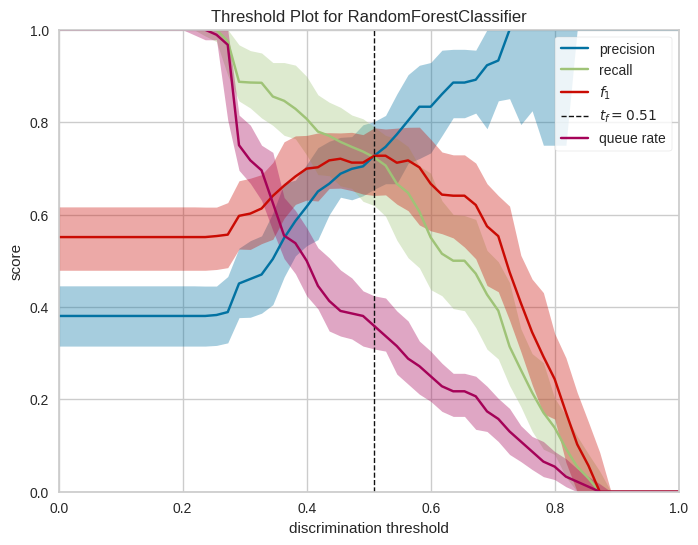

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
dt_viz = DiscriminationThreshold(rf_balanced)
dt_viz.fit(X_train, y_train)
dt_viz.poof();

In [ ]:
#Caso se buscasse precision ou recall, o gráfico acima ajudaria a entrontrar o melhor threshold.aa

## Shapley

In [ ]:
# O pacote SHAP (SHapley Additive exPlanations) é capaz de exibir as contribuições das features para qualquer modelo.

# O SHAP funciona tanto para classificação como para regressão e gera valores “SHAP”.
# Para modelos de classificação, o valor SHAP é a soma dos log odds (logaritmo das chances) em uma classificação binária.
# Para regressão, os valores SHAP são a soma da predição do alvo.

In [ ]:
#instanciar o Shap, carregar o modelo, e o dataset
s = shap.TreeExplainer(rf_balanced)
shap_vals = s.shap_values(X_train)
target_idx = 1 #Usaremos o índice de sobrevivência (1) porque queremos que o lado direito do gráfico seja a sobrevivência

In [ ]:
#Visualizar o primeiro passageiro
X_train[:1]
#é uma mulher

,pclass,age,sibsp,parch,sex_female,embarked_C,embarked_Q,embarked_S
0,0,-0.933954,1,0,1,0,0,1


In [ ]:
#Probabilidades do primeiro passageiro sobreviver ou não
rf_balanced.predict_proba(X_train.iloc[[1]])

array([[0.72153267, 0.27846733]])

In [ ]:
#72% para sobreviver, logo survived=1

In [ ]:
#confirmar que previu survived=1 (sim)
rf_balanced.predict(X_train.iloc[:1])

array([1])

In [ ]:
#Visualizar do primeiro passageiro, quais features impactaram neste resultado:

shap.initjs() #Colab precisa iniciar o js em cada celula para plotar

shap_vals1 = s.shap_values(X_train[:1])

shap.force_plot(
  s.expected_value[1],
  shap_vals1[1],
  feature_names=X_train.columns,
)

In [ ]:
#Contribuições dos atributos no Shapley para a amostra 1.
#Quanto maior o atributo, mais impacto ele causará. Neste caso, sex_female e p_class estão pressionando muito em direção a sobrevivência (rosa)
#já embarked_C, parch e embarked_S pressionam em direção a não sobrevivência (azul), porém com uma intensidade bem menos (assim como sibsp)

In [ ]:
#avaliar os passageiros 1 ao 7:
y_train[:7]

92      1
1284    0
1177    0
748     0
768     0
837     0
35      1
Name: survived, dtype: int64

In [ ]:
#2 deles sobreviveram

#vamos olhar quantos são mulheres
X_train[:7]

,pclass,age,sibsp,parch,sex_female,embarked_C,embarked_Q,embarked_S
0,0,-0.933954,1,0,1,0,0,1
1,2,-0.101932,0,0,0,0,0,1
2,2,-0.101932,6,2,0,0,0,1
3,2,0.351899,1,1,0,0,0,1
4,2,-0.101932,0,0,0,0,0,1
5,2,0.578814,2,0,0,0,0,1
6,0,1.183921,0,0,1,1,0,0


In [ ]:
#os 2 sobreviventes são mulheres

In [ ]:
#Visualizar os passageiros 1 ao 7 (vai ordenar abaixo com os sobreviventes à esquerda do eixo x do gráfico)

shap.initjs() #Colab precisa iniciar o js em cada celula para plotar

shap_vals_1a7 = s.shap_values(X_train[:100])

shap.force_plot(
  s.expected_value[1],
  shap_vals_1a7[1],
  feature_names=X_train.columns,
)

NameError: ignored

In [ ]:
#agora, vemos na vertical, aquele gráfico que antes viamos na horizontal para apenas uma amostra
#para o primeiro passageiro (zero no eixo x), temos 0.74% de probabilidade de sobrevivência: as features p_class e sex_female direcionam para cima (sobrevivência)

In [ ]:
#visualizando agora, para todo o dataset:
shap.initjs()

shap.force_plot(
  s.expected_value[1],
  shap_vals[1],
  feature_names=X_train.columns,
)

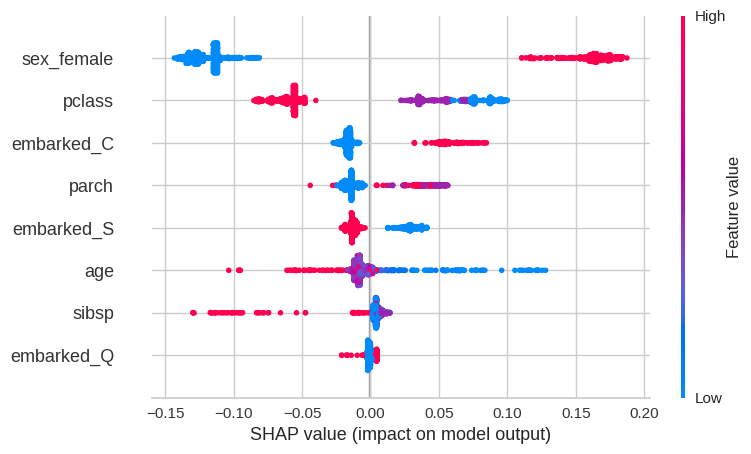

In [ ]:
#A biblioteca SHAP também pode fazer uma síntese de todos os atributos!
#Esse é um gráfico muito eficaz para a compreensão dos dados. Ele mostra o impacto global, mas também os impactos individuais.
#Os atributos são classificados segundo a importância, e os mais importantes estão na parte superior.
#Além disso, os atributos recebem cores de acordo com seus valores.
#Podemos ver que uma pontuação baixa para sex_male (ou seja, sexo feminino) pressiona mais em direção à sobrevivência (rosa), enquanto uma pontuação alta exerce pressão contrária (azul).

shap.summary_plot(shap_vals[1], X_train)

In [ ]:
#criar um dataset apenas com passageiros do sexo feminino, e plotar novamente o gráfico:
X_train_female = X_train.loc[X_train.sex_female == 1]
X_train_female.shape

(334, 8)

In [ ]:
#instanciar o Shap, carregar o modelo, e o dataset
s_fem = shap.TreeExplainer(rf_balanced)
shap_vals_fem = s_fem.shap_values(X_train_female)

In [ ]:
#visualizando agora, para todo o dataset:
shap.initjs()

shap.force_plot(
  s_fem.expected_value[1],
  shap_vals_fem[1],
  feature_names=X_train.columns,
)

In [ ]:
#praticamente 300 de 350 pasageiras mulheres foram classificadas como sobreviventes, de fato, a variável tem um impacto muito forte.

In [ ]:
#Explorar em mais detalhes: https://www.youtube.com/watch?v=J5E4umn8Fb4